<a href="https://colab.research.google.com/github/RKCZ/woody_filter/blob/main/woody_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Demo of Woody adaptive filter
==
This notebook demonstrates basic usage of `woody_filter` python module.

In [1]:
!pip install mne
!pip install ipympl
!wget https://raw.githubusercontent.com/RKCZ/woody_filter/main/woody_filter.py

     |████████████████████████████████| 112kB 4.3MB/s 
--2021-02-08 16:44:31--  https://raw.githubusercontent.com/RKCZ/woody_filter/main/woody_filter.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4860 (4.7K) [text/plain]
Saving to: ‘woody_filter.py.1’

woody_filter.py.1   100%[===================>]   4.75K  --.-KB/s    in 0s      

2021-02-08 16:44:31 (51.6 MB/s) - ‘woody_filter.py.1’ saved [4860/4860]



In [2]:
import mne
import os
import matplotlib.pyplot as plt
import numpy as np
import woody_filter

Next cell demonstrates usage of `woody_filter_raw` on synthetic data signal.
Firstly, time range and arbitrary math function are specified.
Some utility functions for visualization and signal generation are defined.
Variables `t` and `signal` can be modified for experimentation, as well as parameters of the `test_signal` function.

Correlation coefficient: 1.0


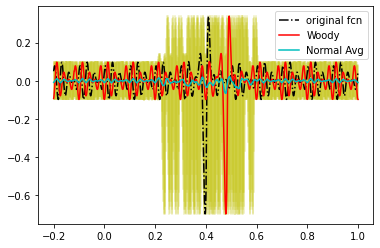

Correlation coefficient: 0.9416752130701324


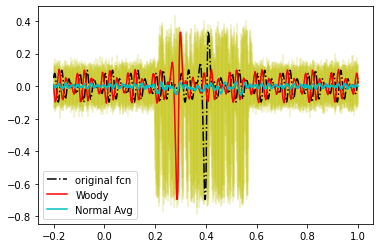

Correlation coefficient: 0.15312146162277807


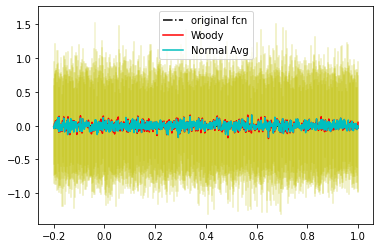

In [3]:
t = np.linspace(-0.2, 1., 1000)
signal = 0.05 * np.sin(80 * np.pi * t) + 0.05 * np.cos(60 * np.pi * t) +\
         np.sin(50 * np.pi * t - np.pi / 4) * np.exp(0.1 * np.hstack((-1*np.arange(500, 0, -1), 0, -1*np.arange(1, 500))))

def __visualize(noisy_signal, result, original_fcn, channel_index = 0):
    """
    Plots a single channel of the filtered averaged signal as well as the original signal,
     time-locked average and unfiltered epochs.
    :param noisy_signal: Array of unfiltered epochs.
    :param result: Array of filtered epochs.
    :param original_fcn: Original signal samples.
    :param channel_index: Index of channel to visualize
    """
    n_elements = noisy_signal.shape[0]
    plt.plot(np.tile(t, (n_elements, 1)), noisy_signal[:, channel_index, :], 'y', alpha=0.2)
    plt.plot(t, original_fcn, '-.k', label='original fcn')
    plt.plot(t, np.mean(result[:, channel_index, :], axis=0), 'r', label='Woody')
    plt.plot(t, np.mean(noisy_signal[:, channel_index, :], axis=0), 'c', label='Normal Avg')
    plt.legend()
    plt.show()

def __noisify(original_signal, n_epochs=50, n_channels=22, max_shift=0,noise_variance = 0.):
    """
    Generates artificial signal from the original signal, shifts it randomly and adds random noise component.
    :param original_signal: Original signal as NumPy array
    :param n_epochs: Number of epochs to generate.
    :param n_channels: Number of channels to generate.
    :param max_shift: Maximal number of samples to shift the original signal while generating epochs.
    :param noise_variance: Variance of the Gaussian distribution used to generate noise.
    :return: Signal generated from original signal.
    """
    data = np.tile(original_signal, (n_epochs * n_channels, 1))
    data = data.reshape((n_epochs, n_channels, -1))
    lags = (np.random.random(data.shape[0]) - 0.5) * (2 * max_shift)
    for i in range(n_epochs):
        data[i, :, :] = np.roll(data[i, :, :], int(np.round(lags[i])))
    noise = np.random.normal(0, noise_variance, data.shape)
    return data + noise

def test_signal(original_signal, noise_variance = 0.0, max_shift = 0):
    """
    Generates artificial signal from original, applies woody filter and visualizes the results.
    :param original_signal: Samples of original signal.
    :param noise_variance: Variance of noise added to generated signal.
    :param max_shift: Maximal shift of the generated signal against the original.
    """
    noisy_signal = __noisify(original_signal, max_shift=max_shift, noise_variance=noise_variance)
    channel = 0
    result, _, corr_coeffs = woody_filter.woody_filter_raw(noisy_signal)
    print('Correlation coefficient: {}'.format(corr_coeffs[channel]))
    __visualize(noisy_signal, result, original_signal, channel)

test_signal(signal, noise_variance=0, max_shift=160)
test_signal(signal, noise_variance=0.03, max_shift=160)
test_signal(np.zeros(t.shape), noise_variance=0.35)

Next cell demonstrates usage of the python-MNE wrapper function to filter EEG epochs extracted from sample dataset
distributed along MNE. The example is based on the following tutorial:
https://mne.tools/stable/auto_tutorials/evoked/plot_10_evoked_overview.html#the-evoked-data-structure-evoked-averaged-data
From the raw signal are extracted EEG epochs related to auditory stimuli. These epochs are passed to `woody_filter`
function. Aligned epochs are converted to MNE Evoked object and plotted.

Using default location ~/mne_data for sample...
Creating ~/mne_data



Verifying hash 12b75d1cb7df9dfb4ad73ed82f61094f.
Decompressing the archive: /root/mne_data/MNE-sample-data-processed.tar.gz
(please be patient, this can take some time)
Successfully extracted to: ['/root/mne_data/MNE-sample-data']
Attempting to create new mne-python configuration file:
/root/.mne/mne-python.json
320 events found
Event IDs: [ 1  2  3  4  5 32]
Not setting metadata
Not setting metadata
145 matching events found
Setting baseline interval to [-0.2996928197375818, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 145 events and 601 original time points ...
0 bad epochs dropped
Not setting metadata
Not setting metadata
145 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Average of averaged correlation coefficients over all channels: 0.4560736480309911


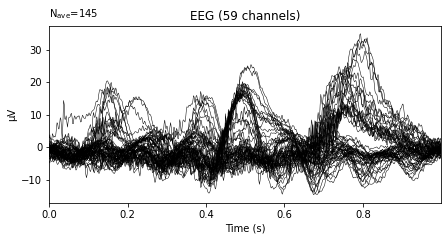

In [4]:
%matplotlib widget

sample_data_folder = mne.datasets.sample.data_path()
sample_data_raw_file = os.path.join(sample_data_folder, 'MEG', 'sample',
                                    'sample_audvis_raw.fif')
raw = mne.io.read_raw_fif(sample_data_raw_file, verbose=False)
raw = raw.pick_types(emg=False, eeg=True, eog=False, stim=True)

events = mne.find_events(raw, stim_channel='STI 014')
event_dict = {'auditory/left': 1, 'auditory/right': 2}
epochs = mne.Epochs(raw, events, tmin=-0.3, tmax=0.7, event_id=event_dict,
                    preload=True)

epochs = epochs.pick_types(eeg=True)
filtered_epochs, latencies, correlations = woody_filter.woody_filter(epochs)
filtered_evokeds = filtered_epochs.average()
filtered_evokeds.plot()
print('Average of averaged correlation coefficients over all channels: {}'.format(correlations.mean()))